# Scraping Sold Houses

### Import Lib

In [1]:
import numpy as np
import requests
import os
import time
import re
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import box
from tqdm import tqdm

### Functions

In [2]:
import time

def time_logger(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Function '{func.__name__}' took {elapsed_time:.2f} seconds to execute.")
        return result
    return wrapper


In [3]:
def setup_driver():
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    return driver

def download_image(image_url, location, base_url='https://www.estately.com', save_dir='../data/estately_images/queens'):
    if not image_url.startswith('http'):
        image_url = base_url + image_url
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    filename = "".join([c for c in location if c.isalpha() or c.isdigit() or c == ' ']).rstrip()
    filename = filename.replace(' ', '_') + '.jpg'
    file_path = os.path.join(save_dir, filename)
    try:
        response = requests.get(image_url)
        if response.status_code == 200:
            with open(file_path, 'wb') as file:
                file.write(response.content)
        else:
            filename = None
    except requests.exceptions.RequestException:
        filename = None 
    return filename

def fetch_on_sales_properties(driver, max_images=300, area = 'NY/New_York'):
    properties = []
    image_count = 0
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    property_divs = soup.find_all('div', class_='result-item-info clearfix')
    print('properties found: ', len(property_divs))
    for div in property_divs:
#         if image_count >= max_images:
#             break
        location_tag = div.find('h2', class_='result-address').find('a')
        location = location_tag.text.strip() if location_tag else "No location provided"
        image_tag = div.find('img', class_='listing-card-image')
        detail_link = 'https://www.estately.com' + location_tag['href'] if location_tag else None

        # Price extraction
        price_tag = div.find('p', class_='result-price')
        price = price_tag.text.strip() if price_tag else "Price not listed"
        
        # Property type extraction
        property_type_tag = div.find('h2', class_='result-address').find('small')
        property_type = property_type_tag.text.strip() if property_type_tag else "Property type not listed"
        
        photo_count_tag = div.parent.find('div', class_='photo-count-small')
        photo_count = photo_count_tag.text.strip() if photo_count_tag else "No photo"
        
        broker_tag = div.parent.find('p')
        broker = broker_tag.text.strip() if broker_tag else "No broker listed"
        
        image_url = image_tag.get('data-src', image_tag.get('src', "No image provided")) if image_tag else "No image provided"
        image_name = None
#         image_name = download_image(image_url, location, save_dir=f'../data/estately/img/{area}')

        # Basic details extraction
        basics_grid = div.find('ul', class_='result-basics-grid')
        beds = baths = sqft = lot_size = days_on_site = None 
        if basics_grid:
            for li in basics_grid.find_all('li'):
                text = li.text.strip()
                if 'bed' in text.lower():
                    beds = text.split()[0]
                elif 'bath' in text.lower():
                    baths = text.split()[0]
                elif 'sqft' in text.lower() and not 'lot' in text.lower():
                    sqft = text.split()[0]
                elif 'lot' in text.lower():
                    lot_size = text.split()[0]
                elif 'on site' in text.lower():
                    days_on_site = text.split()[0]
        properties.append({
            'Location': location,
            'Detail Link': detail_link,
            'Image Name': image_name,
            'Price': price,
            'Property Type': property_type,
            'Photo Count': photo_count,
            'Broker': broker,
            'Beds': beds,
            'Baths': baths,
            'Sqft': sqft,
            'Lot Size': lot_size,
            'Days on Site': days_on_site
        })
        image_count += 1
        if image_count % 20 == 0:
            print(f"Scraped {image_count} images.")
    return properties

def fetch_sold_properties(driver, max_images=300, area = 'NY/New_York'):
    properties = []
    image_count = 0
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    property_divs = soup.find_all('div', class_='result-item-info clearfix')
    print('properties found: ', len(property_divs))
    if len(property_divs) == 200:
        return properties, 200
    for div in property_divs:
#         if image_count >= max_images:
#             break
        location_tag = div.find('h2', class_='result-address').find('a')
        location = location_tag.text.strip() if location_tag else "No location provided"
        image_tag = div.find('img', class_='listing-card-image')
        detail_link = 'https://www.estately.com' + location_tag['href'] if location_tag else None

        # Price extraction
        price_tag = div.find('p', class_='result-price')
        price = price_tag.text.strip() if price_tag else "Price not listed"
        
        # Property type extraction
        property_type_tag = div.find('h2', class_='result-address').find('small')
        property_type = property_type_tag.text.strip() if property_type_tag else "Property type not listed"
        
        photo_count_tag = div.parent.find('div', class_='photo-count-small')
        photo_count = photo_count_tag.text.strip() if photo_count_tag else "No photo"
        
        broker_tag = div.parent.find('p')
        broker = broker_tag.text.strip() if broker_tag else "No broker listed"
        
        image_url = image_tag.get('data-src', image_tag.get('src', "No image provided")) if image_tag else "No image provided"
        image_name = None
        image_name = download_image(image_url, location, save_dir=f'../data/estately/img/{area}')

        sold_date_tag = div.find('small', string=re.compile(r'\d{1,2}/\d{1,2}/\d{2}'))
        sold_date = sold_date_tag.get_text(strip=True) if sold_date_tag else 'date not listed'

        # Basic details extraction
        basics_grid = div.find('ul', class_='result-basics-grid')
        beds = baths = sqft = lot_size = None 
        if basics_grid:
            for li in basics_grid.find_all('li'):
                text = li.text.strip()
                if 'bed' in text.lower():
                    beds = text.split()[0]
                elif 'bath' in text.lower():
                    baths = text.split()[0]
                elif 'sqft' in text.lower() and not 'lot' in text.lower():
                    sqft = text.split()[0]
                elif 'lot' in text.lower():
                    lot_size = text.split()[0]
        properties.append({
            'Location': location,
            'Detail Link': detail_link,
            'Image Name': image_name,
            'Price': price,
            'Property Type': property_type,
            'Photo Count': photo_count,
            'Broker': broker,
            'Beds': beds,
            'Baths': baths,
            'Sqft': sqft,
            'Lot Size': lot_size,
            'Sold Date': sold_date
        })
        image_count += 1
        if image_count % 20 == 0:
            print(f"Scraped {image_count} images.")
    return properties, len(property_divs)

def main(max_images=300, area = 'NY/New_York', scraping_type = None):
    url = f'https://www.estately.com/{area}'
    if scraping_type and 'sold' in scraping_type:
        url += '?only_sold=sold'
    
    print(area)
    driver = setup_driver()
    driver.get(url)
    time.sleep(5)
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#     time.sleep(5)
    if scraping_type and 'sold' in scraping_type:
        properties = fetch_sold_properties(driver, max_images, area)
    else:
        properties = fetch_on_sales_properties(driver, max_images, area)

    driver.quit()
    df = pd.DataFrame(properties)
    return df

### Get Census Tracts Boundaries

In [4]:
import pandas as pd

# Load the CSV file
csv_file_path = '../docs/HMDACensus.xlsx'
census_data = pd.read_excel(csv_file_path)
print(census_data.head())


   state_code  county_code  census_tract_number  as_of_year  loanN  \
0           1            1                201.0        2017     30   
1           1            1                202.0        2017     34   
2           1            1                203.0        2017     78   
3           1            1                204.0        2017    100   
4           1            1                206.0        2017     83   

   population       GEOID   INTPTLAT   INTPTLON  
0        1948  1001020100  32.481973 -86.491565  
1        2156  1001020200  32.475758 -86.472468  
2        2968  1001020300  32.474024 -86.459703  
3        4423  1001020400  32.471030 -86.444835  
4        3851  1001020600  32.447340 -86.476828  


In [ ]:
import requests
import zipfile
import os

def download_shapefiles(year=2023, entity='tract', resolution='5m', download_dir='shapefiles'):
    base_url = 'https://www2.census.gov/geo/tiger/GENZ{year}/shp/cb_{year}_us_{entity}_{resolution}.zip'
    url = base_url.format(year=year, entity=entity, resolution=resolution)
    print(url)
    # Create download directory if it doesn't exist
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    
    # Download the zip file
    zip_file_path = os.path.join(download_dir, f'cb_{year}_us_{entity}_{resolution}.zip')
    response = requests.get(url)
    if response.status_code == 200:
        with open(zip_file_path, 'wb') as file:
            file.write(response.content)
        print(f'Downloaded shapefile to {zip_file_path}')
        
        # Extract the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(download_dir)
        print(f'Extracted shapefiles to {download_dir}')
    else:
        print(f'Failed to download shapefile. Status code: {response.status_code}')
        print(f'URL attempted: {url}')

# Example usage
download_shapefiles(year=2023, entity='tract', resolution='5m')


In [ ]:
import geopandas as gpd

# Load the shape files
shape_file_path = 'shapefiles/cb_2023_us_tract_5m.shp'
tracts = gpd.read_file(shape_file_path)

# Ensure state_code, county_code, and census_tract are strings
census_data['state_code'] = census_data['state_code'].astype(str).str.zfill(2)
census_data['county_code'] = census_data['county_code'].astype(str).str.zfill(3)
census_data['GEOID'] = census_data['GEOID'].astype(str).str.zfill(10)

tracts['STATEFP'] = tracts['STATEFP'].astype(str).str.zfill(2)
tracts['COUNTYFP'] = tracts['COUNTYFP'].astype(str).str.zfill(3)
tracts['GEOID'] = tracts['GEOID'].astype(str).str.zfill(10)

# merge files
census_tracts = pd.merge(census_data, tracts, left_on=['state_code', 'county_code', 'GEOID'], right_on=['STATEFP', 'COUNTYFP', 'GEOID'])


### Run

In [4]:

def generate_grid_within_boundary(boundary, step=0.002):
    minx, miny, maxx, maxy = boundary.bounds
    grids = []
    x = minx
    while x < maxx:
        y = miny
        while y < maxy:
            grid = box(x, y, x + step, y + step)
            if grid.intersects(boundary):
                grids.append(grid)
                # Plot the grid
                x1, y1, x2, y2 = grid.bounds
                plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b-')
            y += step
        x += step
    print('Scraping the following tract, total: ', len(grids))
    
    plt.axis('equal')
    plt.show()
    return grids

In [5]:
# Function to scrape properties for each grid
def main_for_census_tract(tract_data, step):
    for index, row in tract_data.iterrows():
        if index == 0:
            continue
        boundary = row['geometry']
        print(f'Scraping tract {index}, area: {round(row.to_dict()["area_sq_km"], 3)} sq km')
        grids = generate_grid_within_boundary(boundary, step)
        for grid in grids:
            minx, miny, maxx, maxy = [round(val, 3) for val in grid.bounds]
            
            # Adjust the main call to use these coordinates
            df_on_sales = main(1, f'{miny},{minx},{maxy},{maxx}')
            print('On sales Scrapped')
            df_sold = main(1, f'{miny},{minx},{maxy},{maxx}', 'sold')
            print('Sold Scrapped')
        if index > 2:
            break
    return df_on_sales, df_sold

Scraping tract 1, area: 3.965 sq km
Scraping the following tract, total:  1


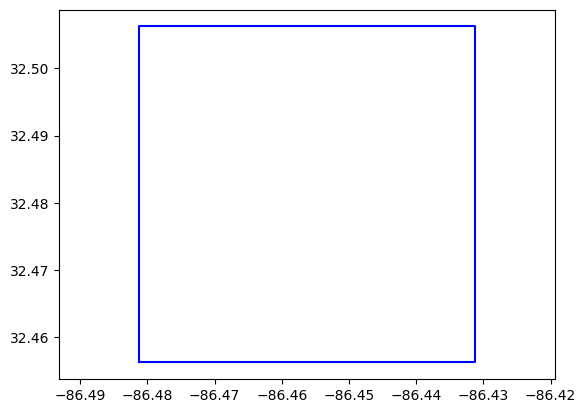

32.456,-86.481,32.506,-86.431
properties found:  14
On sales Scrapped
32.456,-86.481,32.506,-86.431


KeyboardInterrupt: 

In [154]:
# test
step = 0.05
tract_data = pd.read_csv('tract_data_usa.csv')
tract_data['geometry'] = tract_data['geometry_shape'].apply(wkt.loads)
gpd.GeoDataFrame(tract_data, geometry='geometry')
df_on_sales, df_sold = main_for_census_tract(tract_data, step)

In [41]:
df_sold

,Location,Detail Link,Image Name,Price,Property Type,Photo Count,Broker,Beds,Baths,Sqft,Lot Size,Sold Date
0,"110 W 6th Street, Bay Minette, AL",https://www.estately.com/listings/info/110-w-6...,None,"$170,000",Sold House,17 photos,Sold House,3,1,"1,599","14,700",06/04/2024
1,"0 Pine Grove Rd Extension, Bay Minette, AL",https://www.estately.com/listings/info/0-pine-...,None,"$60,000",Sold Land,1 photo,Sold Land,–,–,–,None,06/03/2024
2,"246 W 16th Street, Bay Minette, AL",https://www.estately.com/listings/info/246-w-1...,None,"$240,000",Sold House,24 photos,Sold House,3,2,"1,434","14,810",05/31/2024
3,"17155 Old Brady Road, Bay Minette, AL",https://www.estately.com/listings/info/17155-o...,None,"$250,000",Sold House,28 photos,Sold House,3,2,"1,584",None,05/31/2024
4,"45562 County Road 112, Bay Minette, AL",https://www.estately.com/listings/info/45562-c...,None,"$283,000",Sold House,23 photos,Sold House,3,2,"1,346",None,05/30/2024
...,...,...,...,...,...,...,...,...,...,...,...,...
195,"120 MARIETTA STREET Unit 27, BAY MINETTE, AL",https://www.estately.com/listings/info/120-mar...,None,"$27,200",Sold Land,1 photo,Sold Land,–,–,–,None,12/16/2022
196,"303 KENNESAW AVENUE Unit 52, BAY MINETTE, AL",https://www.estately.com/listings/info/303-ken...,None,"$27,200",Sold Land,1 photo,Sold Land,–,–,–,None,12/16/2022
197,"307 KENNESAW AVENUE Unit 50, BAY MINETTE, AL",https://www.estately.com/listings/info/307-ken...,None,"$27,200",Sold Land,1 photo,Sold Land,–,–,–,None,12/16/2022
198,"118 MARIETTA STREET Unit 26, BAY MINETTE, AL",https://www.estately.com/listings/info/118-mar...,None,"$27,200",Sold Land,1 photo,Sold Land,–,–,–,None,12/16/2022


## Recursive Grid Scraping 

In [6]:
@time_logger
def recursive_grid_scraping(miny, minx, maxy, maxx, step, scraping_type=None):
    df_list = []
    main_call = lambda my, mx, my2, mx2: main(1, f'{my},{mx},{my2},{mx2}', scraping_type)

    def scrape_and_check_grid(my, mx, my2, mx2, current_step):
        df, count = main_call(my, mx, my2, mx2)
        if count >= 200 and current_step > 0.002:            
            new_step = current_step / 2
            print(f'breakdown steps to: {new_step}')
            grid_bounds = [
                (my, mx, (my + my2) / 2, (mx + mx2) / 2),
                (my, (mx + mx2) / 2, (my + my2) / 2, mx2),
                ((my + my2) / 2, mx, my2, (mx + mx2) / 2),
                ((my + my2) / 2, (mx + mx2) / 2, my2, mx2)
            ]
            for bounds in grid_bounds:
                df_list.extend(scrape_and_check_grid(*bounds, new_step))
        else:
            df_list.append(df)
        return df_list

    scrape_and_check_grid(miny, minx, maxy, maxx, step)
    return pd.concat(df_list)


def main_for_census_tract(tract_data, step):
    
    for index, row in tract_data.iterrows():
        geoid = row['GEOID']
        # results directory
        results_dir = os.path.join('results', geoid)
        cache_dir = os.path.join(results_dir, 'cache')
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
        
        print(f'Scraping tract {index}, area: {round(row.to_dict()["area_sq_km"], 3)} sq km')
        boundary = row['geometry']
        grids = generate_grid_within_boundary(boundary, step)
        df_on_sales_list = []
        df_sold_list = []
        for i, grid in enumerate(tqdm(grids, desc=f"Scraping grids for tract {index}")):
            minx, miny, maxx, maxy = [round(val, 3) for val in grid.bounds]
            
            # print(f"Scraping grid: {miny},{minx},{maxy},{maxx}")
            df_on_sales = recursive_grid_scraping(miny, minx, maxy, maxx, step)
            # print('On sales Scrapped')
            df_sold = recursive_grid_scraping(miny, minx, maxy, maxx, step, 'sold')
            # print('Sold Scrapped')
            df_on_sales_list.append(df_on_sales)
            df_sold_list.append(df_sold)
            
            if (i + 1) % 10 == 0:
                on_sales_cache_path = os.path.join(cache_dir, f'df_on_sales_list_tract_{index}_part_{i//10}.csv')
                pd.concat(df_on_sales_list, ignore_index=True).to_csv(on_sales_cache_path, index=False)
                df_on_sales_list = []  # Clear the list after caching

                sold_cache_path = os.path.join(cache_dir, f'df_sold_list_tract_{index}_part_{i//10}.csv')
                pd.concat(df_sold_list, ignore_index=True).to_csv(sold_cache_path, index=False)
                df_sold_list = []  # Clear the list after caching
        if df_on_sales_list:
            on_sales_cache_path = os.path.join(cache_dir, f'df_on_sales_list_tract_{index}_part_{i//10}.csv')
            pd.concat(df_on_sales_list, ignore_index=True).to_csv(on_sales_cache_path, index=False)
        if df_sold_list:
            sold_cache_path = os.path.join(cache_dir, f'df_sold_list_tract_{index}_part_{i//10}.csv')
            pd.concat(df_sold_list, ignore_index=True).to_csv(sold_cache_path, index=False)
        
        # Combine cached files into final DataFrames
        df_on_sales_combined = pd.concat(
            [pd.read_csv(os.path.join(cache_dir, f)) for f in os.listdir(cache_dir) if 'on_sales' in f],
            ignore_index=True
        )
        df_sold_combined = pd.concat(
            [pd.read_csv(os.path.join(cache_dir, f)) for f in os.listdir(cache_dir) if 'sold' in f],
            ignore_index=True
        )
        # Save combined DataFrames for the tract
        on_sales_combined_path = os.path.join(results_dir, f'{geoid}_on_sales.csv')
        df_on_sales_combined.to_csv(on_sales_combined_path, index=False)

        sold_combined_path = os.path.join(results_dir, f'{geoid}_sold.csv')
        df_sold_combined.to_csv(sold_combined_path, index=False)
        
        # Clean up cache directory
        for f in os.listdir(cache_dir):
            os.remove(os.path.join(cache_dir, f))

    return df_on_sales_combined, df_sold_combined

def main(max_images=300, area='NY/New_York', scraping_type=None):
    url = f'https://www.estately.com/{area}'
    if scraping_type and 'sold' in scraping_type:
        url += '?only_sold=sold'
    
    # print(area)
    driver = setup_driver()
    driver.get(url)
    time.sleep(5)
    
    if scraping_type and 'sold' in scraping_type:
        properties, count = fetch_sold_properties(driver, max_images, area)
    else:
        properties = fetch_on_sales_properties(driver, max_images, area)
        count = 0
    driver.quit()
    df = pd.DataFrame(properties)
    return df, count


Scraping tract 5, area: 27.724 sq km
Scraping the following tract, total:  1


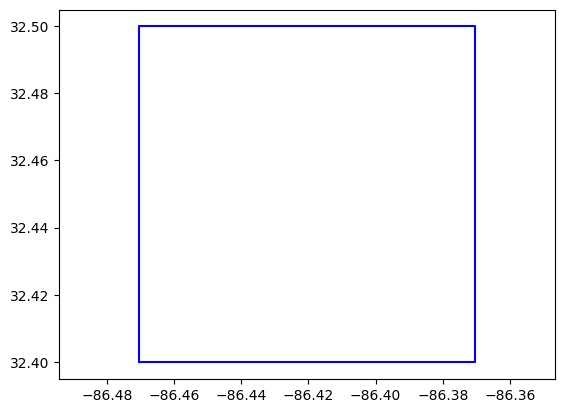

Scraping grid: 32.4,-86.47,32.5,-86.37
32.4,-86.47,32.5,-86.37
properties found:  20
Scraped 20 images.
On sales Scrapped
32.4,-86.47,32.5,-86.37
properties found:  69
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Sold Scrapped
Scraping tract 6, area: 164.035 sq km
Scraping the following tract, total:  4


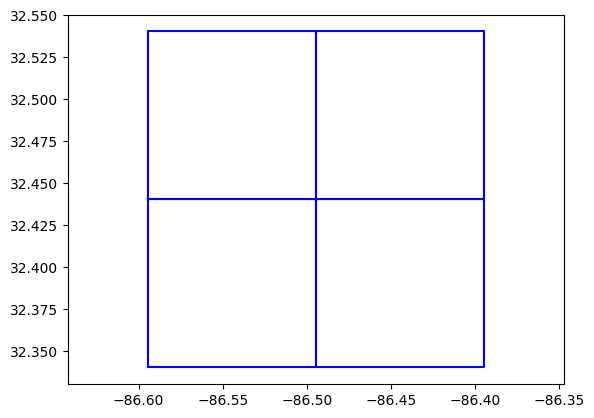

Scraping grid: 32.34,-86.595,32.44,-86.495
32.34,-86.595,32.44,-86.495
properties found:  4
On sales Scrapped
32.34,-86.595,32.44,-86.495
properties found:  26
Scraped 20 images.
Sold Scrapped
Scraping grid: 32.44,-86.595,32.54,-86.495
32.44,-86.595,32.54,-86.495
properties found:  7
On sales Scrapped
32.44,-86.595,32.54,-86.495
properties found:  33
Scraped 20 images.
Sold Scrapped
Scraping grid: 32.34,-86.495,32.44,-86.395
32.34,-86.495,32.44,-86.395
properties found:  17
On sales Scrapped
32.34,-86.495,32.44,-86.395
properties found:  58
Scraped 20 images.
Scraped 40 images.
Sold Scrapped
Scraping grid: 32.44,-86.495,32.54,-86.395
32.44,-86.495,32.54,-86.395
properties found:  18
On sales Scrapped
32.44,-86.495,32.54,-86.395
properties found:  68
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Sold Scrapped
Scraping tract 7, area: 472.643 sq km
Scraping the following tract, total:  7


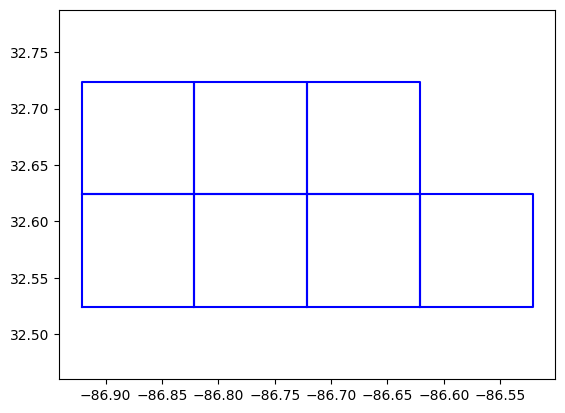

Scraping grid: 32.524,-86.921,32.624,-86.821
32.524,-86.921,32.624,-86.821
properties found:  4
On sales Scrapped
32.524,-86.921,32.624,-86.821
properties found:  22
Scraped 20 images.
Sold Scrapped
Scraping grid: 32.624,-86.921,32.724,-86.821
32.624,-86.921,32.724,-86.821
properties found:  15
On sales Scrapped
32.624,-86.921,32.724,-86.821
properties found:  137
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Scraped 80 images.
Scraped 100 images.
Scraped 120 images.
Sold Scrapped
Scraping grid: 32.524,-86.821,32.624,-86.721
32.524,-86.821,32.624,-86.721
properties found:  1
On sales Scrapped
32.524,-86.821,32.624,-86.721
properties found:  20
Scraped 20 images.
Sold Scrapped
Scraping grid: 32.624,-86.821,32.724,-86.721
32.624,-86.821,32.724,-86.721
properties found:  17
On sales Scrapped
32.624,-86.821,32.724,-86.721
properties found:  144
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Scraped 80 images.
Scraped 100 images.
Scraped 120 images.
Scraped 140 images.


In [157]:
# test recursive
step = 0.1
tract_data = pd.read_csv('tract_data_usa.csv')
tract_data['geometry'] = tract_data['geometry_shape'].apply(wkt.loads)
gpd.GeoDataFrame(tract_data, geometry='geometry')
df_on_sales_combined, df_sold_combined = main_for_census_tract(tract_data, step)

### Demo

Scraping the following tract, total:  20


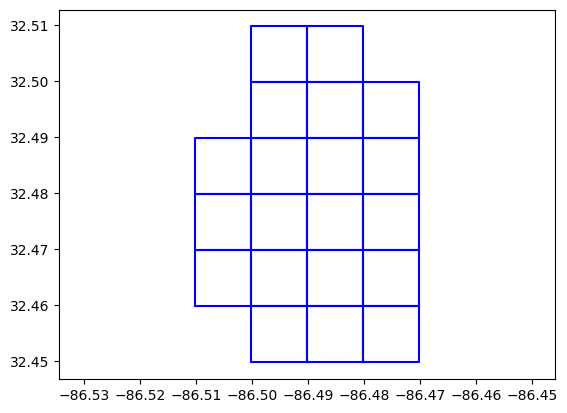

In [71]:
import folium
from shapely.geometry import box, Polygon

# Function to scrape properties for each grid
def main_for_test(tract_data, ind):
    for index, row in tract_data.iterrows():
        if index != ind:
            continue
        boundary = row['geometry']
        m = generate_grid_test(boundary)
        return m
def generate_grid_test(boundary, step=0.01):
    minx, miny, maxx, maxy = boundary.bounds
    grids = []
    x = minx
    while x < maxx:
        y = miny
        while y < maxy:
            grid = box(x, y, x + step, y + step)
            if grid.intersects(boundary):
                grids.append(grid)
                # Plot the grid
                x1, y1, x2, y2 = grid.bounds
                plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b-')
            y += step
        x += step
    print('Scraping the following tract, total: ', len(grids))
    
    plt.axis('equal')
    plt.show()
    
    # Create a Folium map
    m = folium.Map(location=[(miny + maxy) / 2, (minx + maxx) / 2], zoom_start=12)

    # Draw the boundary on the map
    x, y = boundary.exterior.xy
    folium.PolyLine([(y, x) for x, y in zip(x, y)]).add_to(m)
    return m

m = main_for_test(tract_data, 0)
m

Scraping the following tract, total:  33


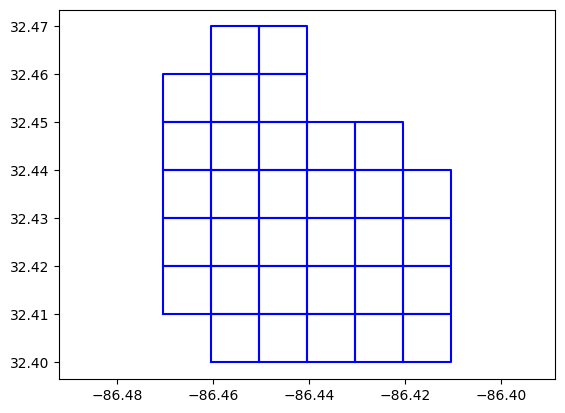

In [72]:
m = main_for_test(tract_data, 5)
m

Scraping the following tract, total:  2


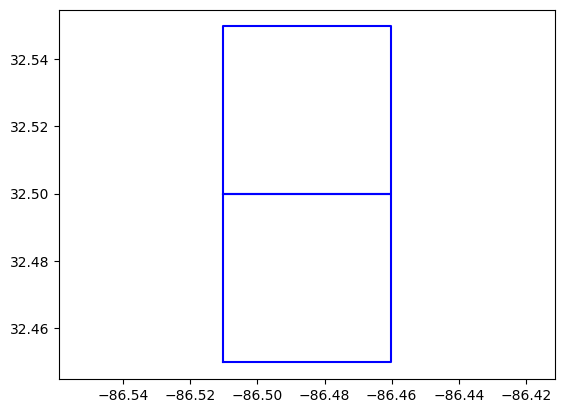

32.45,-86.51,32.5,-86.46
properties found:  3
On sales Scrapped
32.45,-86.51,32.5,-86.46
properties found:  23
Scraped 20 images.
Sold Scrapped
32.5,-86.51,32.55,-86.46
properties found:  2
On sales Scrapped
32.5,-86.51,32.55,-86.46
properties found:  20
Scraped 20 images.
Sold Scrapped
Scraping the following tract, total:  1


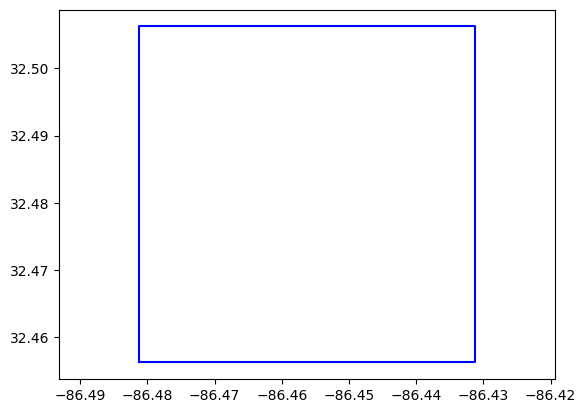

32.456,-86.481,32.506,-86.431
properties found:  14
On sales Scrapped
32.456,-86.481,32.506,-86.431
properties found:  29
Scraped 20 images.
Sold Scrapped
Scraping the following tract, total:  1


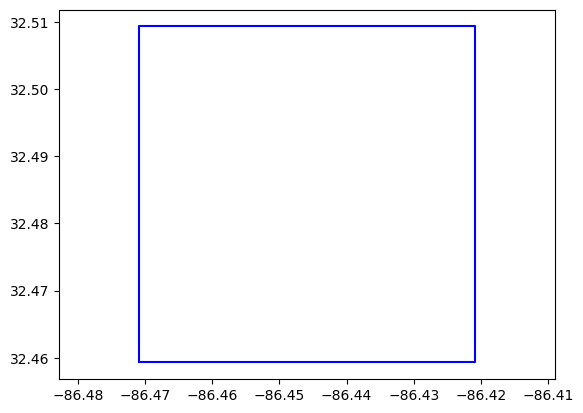

32.459,-86.471,32.509,-86.421
properties found:  14
On sales Scrapped
32.459,-86.471,32.509,-86.421
properties found:  30
Scraped 20 images.
Sold Scrapped
Scraping the following tract, total:  1


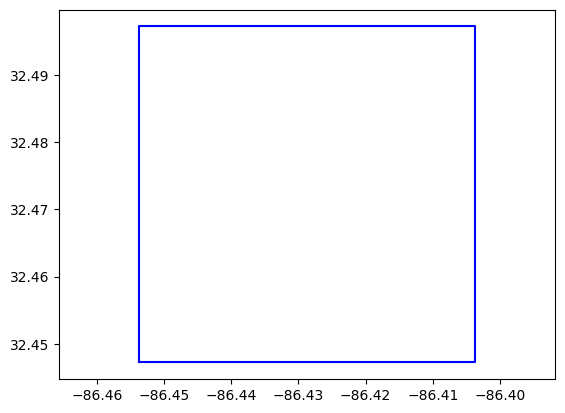

32.447,-86.454,32.497,-86.404
properties found:  15
On sales Scrapped
32.447,-86.454,32.497,-86.404
properties found:  32
Scraped 20 images.
Sold Scrapped
Scraping the following tract, total:  1


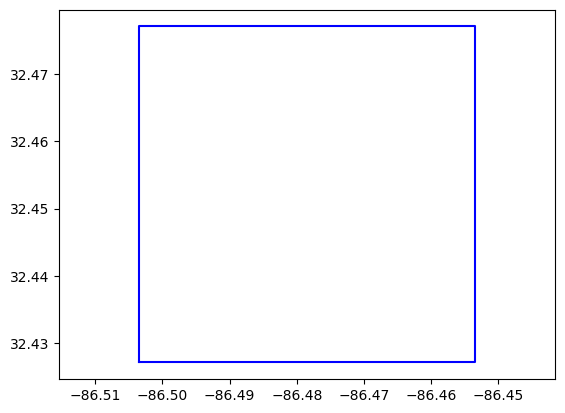

32.427,-86.503,32.477,-86.453
properties found:  5
On sales Scrapped
32.427,-86.503,32.477,-86.453
properties found:  23
Scraped 20 images.
Sold Scrapped
Scraping the following tract, total:  3


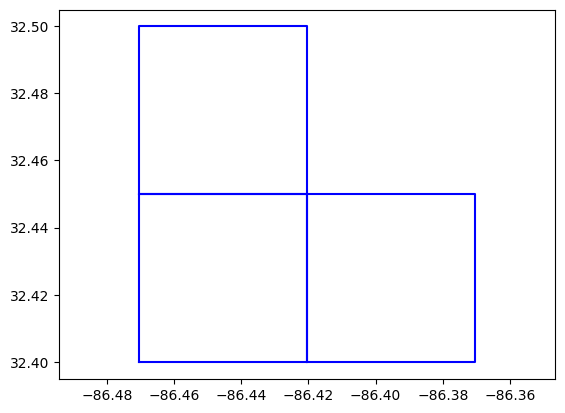

32.4,-86.47,32.45,-86.42
properties found:  14
On sales Scrapped
32.4,-86.47,32.45,-86.42
properties found:  25
Scraped 20 images.
Sold Scrapped
32.45,-86.47,32.5,-86.42
properties found:  14
On sales Scrapped
32.45,-86.47,32.5,-86.42
properties found:  30
Scraped 20 images.
Sold Scrapped
32.4,-86.42,32.45,-86.37
properties found:  11
On sales Scrapped
32.4,-86.42,32.45,-86.37
properties found:  17
Sold Scrapped
Scraping the following tract, total:  10


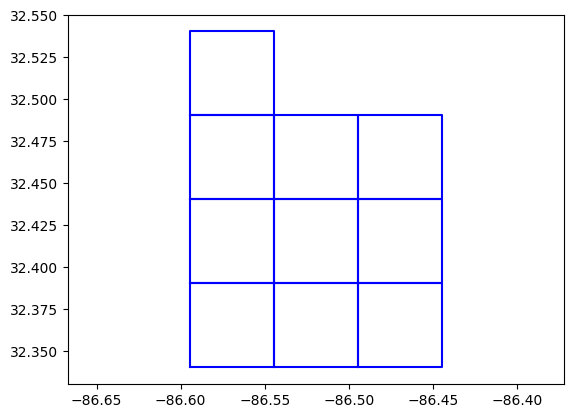

32.34,-86.595,32.39,-86.545
properties found:  0
On sales Scrapped
32.34,-86.595,32.39,-86.545
properties found:  3
Sold Scrapped
32.39,-86.595,32.44,-86.545
properties found:  0
On sales Scrapped
32.39,-86.595,32.44,-86.545
properties found:  3
Sold Scrapped
32.44,-86.595,32.49,-86.545
properties found:  1
On sales Scrapped
32.44,-86.595,32.49,-86.545
properties found:  5
Sold Scrapped
32.49,-86.595,32.54,-86.545
properties found:  3
On sales Scrapped
32.49,-86.595,32.54,-86.545
properties found:  7
Sold Scrapped
32.34,-86.545,32.39,-86.495
properties found:  0
On sales Scrapped
32.34,-86.545,32.39,-86.495
properties found:  1
Sold Scrapped
32.39,-86.545,32.44,-86.495
properties found:  1
On sales Scrapped
32.39,-86.545,32.44,-86.495
properties found:  9
Sold Scrapped
32.44,-86.545,32.49,-86.495
properties found:  1
On sales Scrapped
32.44,-86.545,32.49,-86.495
properties found:  13
Sold Scrapped
32.34,-86.495,32.39,-86.445
properties found:  0
On sales Scrapped
32.34,-86.495,32.39,-8

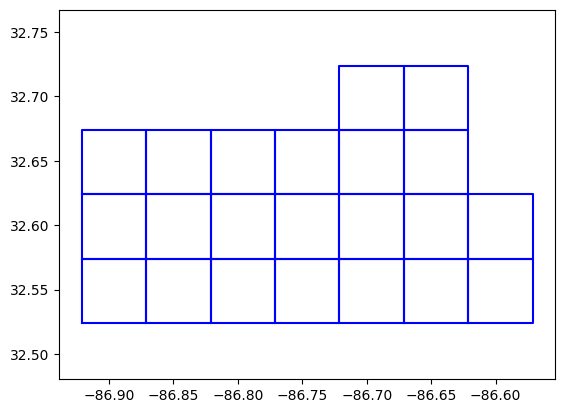

32.524,-86.921,32.574,-86.871
properties found:  1
On sales Scrapped
32.524,-86.921,32.574,-86.871
properties found:  1
Sold Scrapped
32.574,-86.921,32.624,-86.871
properties found:  1
On sales Scrapped
32.574,-86.921,32.624,-86.871
properties found:  9
Sold Scrapped
32.624,-86.921,32.674,-86.871
properties found:  3
On sales Scrapped
32.624,-86.921,32.674,-86.871
properties found:  10
Sold Scrapped
32.524,-86.871,32.574,-86.821
properties found:  1
On sales Scrapped
32.524,-86.871,32.574,-86.821
properties found:  2
Sold Scrapped
32.574,-86.871,32.624,-86.821
properties found:  0
On sales Scrapped
32.574,-86.871,32.624,-86.821
properties found:  2
Sold Scrapped
32.624,-86.871,32.674,-86.821
properties found:  2
On sales Scrapped
32.624,-86.871,32.674,-86.821
properties found:  7
Sold Scrapped
32.524,-86.821,32.574,-86.771
properties found:  0
On sales Scrapped
32.524,-86.821,32.574,-86.771
properties found:  2
Sold Scrapped
32.574,-86.821,32.624,-86.771
properties found:  1
On sales S

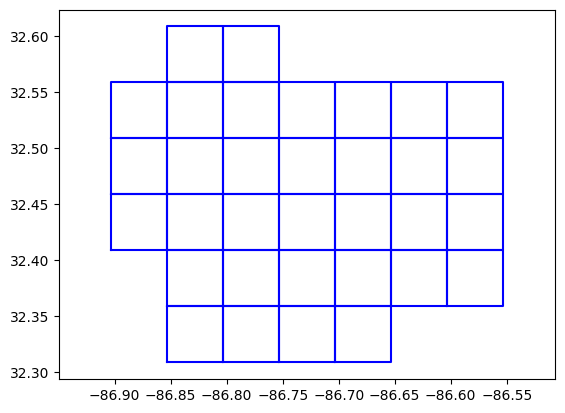

32.409,-86.903,32.459,-86.853
properties found:  1
On sales Scrapped
32.409,-86.903,32.459,-86.853
properties found:  3
Sold Scrapped
32.459,-86.903,32.509,-86.853
properties found:  1
On sales Scrapped
32.459,-86.903,32.509,-86.853
properties found:  4
Sold Scrapped
32.509,-86.903,32.559,-86.853
properties found:  1
On sales Scrapped
32.509,-86.903,32.559,-86.853
properties found:  3
Sold Scrapped
32.309,-86.853,32.359,-86.803
properties found:  0
On sales Scrapped
32.309,-86.853,32.359,-86.803
properties found:  0
Sold Scrapped
32.359,-86.853,32.409,-86.803
properties found:  0
On sales Scrapped
32.359,-86.853,32.409,-86.803
properties found:  0
Sold Scrapped
32.409,-86.853,32.459,-86.803
properties found:  0
On sales Scrapped
32.409,-86.853,32.459,-86.803
properties found:  0
Sold Scrapped
32.459,-86.853,32.509,-86.803
properties found:  0
On sales Scrapped
32.459,-86.853,32.509,-86.803
properties found:  0
Sold Scrapped
32.509,-86.853,32.559,-86.803
properties found:  0
On sales Sc

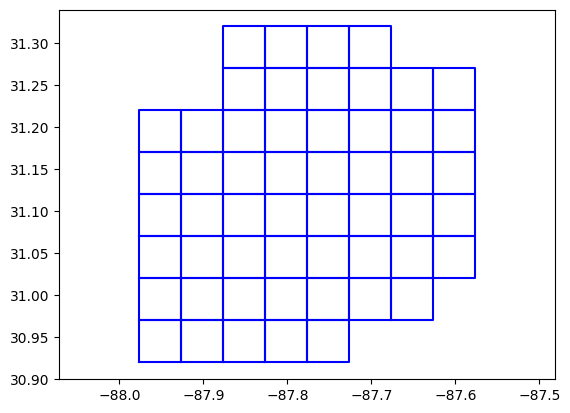

30.919,-87.976,30.969,-87.926
properties found:  0
On sales Scrapped
30.919,-87.976,30.969,-87.926
properties found:  1
Sold Scrapped
30.969,-87.976,31.019,-87.926
properties found:  0
On sales Scrapped
30.969,-87.976,31.019,-87.926
properties found:  0
Sold Scrapped
31.019,-87.976,31.069,-87.926
properties found:  1
On sales Scrapped
31.019,-87.976,31.069,-87.926
properties found:  2
Sold Scrapped
31.069,-87.976,31.119,-87.926
properties found:  1
On sales Scrapped
31.069,-87.976,31.119,-87.926
properties found:  2
Sold Scrapped
31.119,-87.976,31.169,-87.926
properties found:  2
On sales Scrapped
31.119,-87.976,31.169,-87.926
properties found:  2
Sold Scrapped
31.169,-87.976,31.219,-87.926
properties found:  1
On sales Scrapped
31.169,-87.976,31.219,-87.926
properties found:  0
Sold Scrapped
30.919,-87.926,30.969,-87.876
properties found:  6
On sales Scrapped
30.919,-87.926,30.969,-87.876
properties found:  78
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Sold Scrapped
30.9

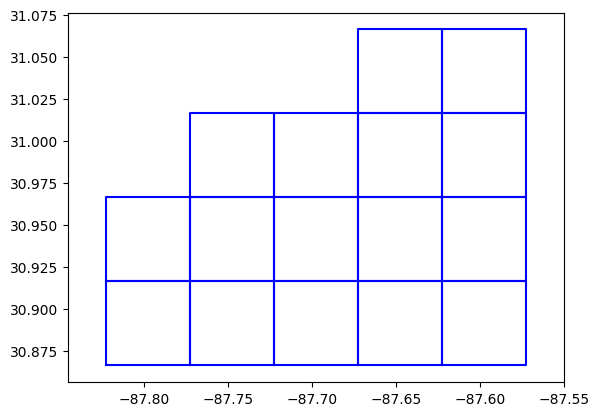

30.866,-87.823,30.916,-87.773
properties found:  70
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
On sales Scrapped
30.866,-87.823,30.916,-87.773
properties found:  200
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Scraped 80 images.
Scraped 100 images.
Scraped 120 images.
Scraped 140 images.
Scraped 160 images.
Scraped 180 images.
Scraped 200 images.
Sold Scrapped
30.916,-87.823,30.966,-87.773
properties found:  55
Scraped 20 images.
Scraped 40 images.
On sales Scrapped
30.916,-87.823,30.966,-87.773
properties found:  200
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Scraped 80 images.
Scraped 100 images.
Scraped 120 images.
Scraped 140 images.
Scraped 160 images.
Scraped 180 images.
Scraped 200 images.
Sold Scrapped
30.866,-87.773,30.916,-87.723
properties found:  67
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
On sales Scrapped
30.866,-87.773,30.916,-87.723
properties found:  200
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Sc

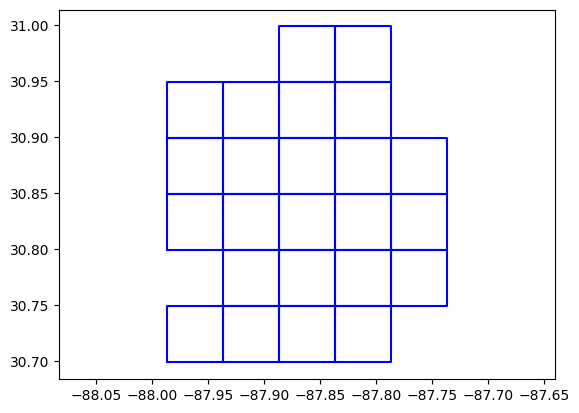

30.699,-87.986,30.749,-87.936
properties found:  7
On sales Scrapped
30.699,-87.986,30.749,-87.936
properties found:  200
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Scraped 80 images.
Scraped 100 images.
Scraped 120 images.
Scraped 140 images.
Scraped 160 images.
Scraped 180 images.
Scraped 200 images.
Sold Scrapped
30.799,-87.986,30.849,-87.936
properties found:  0
On sales Scrapped
30.799,-87.986,30.849,-87.936
properties found:  4
Sold Scrapped
30.849,-87.986,30.899,-87.936
properties found:  0
On sales Scrapped
30.849,-87.986,30.899,-87.936
properties found:  4
Sold Scrapped
30.899,-87.986,30.949,-87.936
properties found:  0
On sales Scrapped
30.899,-87.986,30.949,-87.936
properties found:  4
Sold Scrapped
30.699,-87.936,30.749,-87.886
properties found:  106
Scraped 20 images.
Scraped 40 images.
Scraped 60 images.
Scraped 80 images.
Scraped 100 images.
On sales Scrapped
30.699,-87.936,30.749,-87.886
properties found:  200
Scraped 20 images.
Scraped 40 images.
Scraped 

In [36]:
# test
step = 0.05
tract_data = pd.read_csv('tract_data_usa.csv')
tract_data['geometry'] = tract_data['geometry'].apply(wkt.loads)
gpd.GeoDataFrame(tract_data, geometry='geometry')
df_on_sales, df_sold = main_for_census_tract(tract_data, step)

### Distribution

In [59]:
import geopandas as gpd

def calculate_tract_areas(geo_df):
    # Check if the GeoDataFrame is in a geographic CRS (e.g., WGS84)
    if geo_df.crs is None:
        geo_df.set_crs(epsg=4326, inplace=True)
    if geo_df.crs.is_geographic:
        # Reproject to a projected CRS (e.g., UTM)
        geo_df = geo_df.to_crs(geo_df.estimate_utm_crs())
    
    # Calculate the area and add it as a new column
    geo_df['area_sq_m'] = geo_df['geometry'].area
    geo_df['area_sq_km'] = geo_df['area_sq_m'] / 1e6  # Convert square meters to square kilometers
    
    return geo_df




In [61]:
# Example usage:
tract_data = pd.read_csv('tract_data.csv')
tract_data['geometry'] = tract_data['geometry'].apply(wkt.loads)
geo_df = gpd.GeoDataFrame(tract_data, geometry='geometry')

# Calculate areas
geo_df_with_areas = calculate_tract_areas(geo_df)

# Display the first few rows to verify
print(geo_df_with_areas[['state_code', 'county_code', 'GEOID','population', 'area_sq_km']].head())

   state_code  county_code       GEOID  population  area_sq_km
0           1            1  1001020100        1948   11.960556
1           1            1  1001020200        2156    3.965478
2           1            1  1001020300        2968    6.825247
3           1            1  1001020400        4423    7.465518
4           1            1  1001020600        3851   11.312476


In [62]:
df_selected = geo_df_with_areas[['state_code', 'county_code', 'GEOID','population', 'area_sq_km']]
df_selected

,state_code,county_code,GEOID,population,area_sq_km
0,1,1,1001020100,1948,11.960556
1,1,1,1001020200,2156,3.965478
2,1,1,1001020300,2968,6.825247
3,1,1,1001020400,4423,7.465518
4,1,1,1001020600,3851,11.312476
...,...,...,...,...,...
59963,72,153,72153750501,6205,2.923657
59964,72,153,72153750502,2122,1.159410
59965,72,153,72153750503,2277,7.905249
59966,72,153,72153750601,5267,22.248456


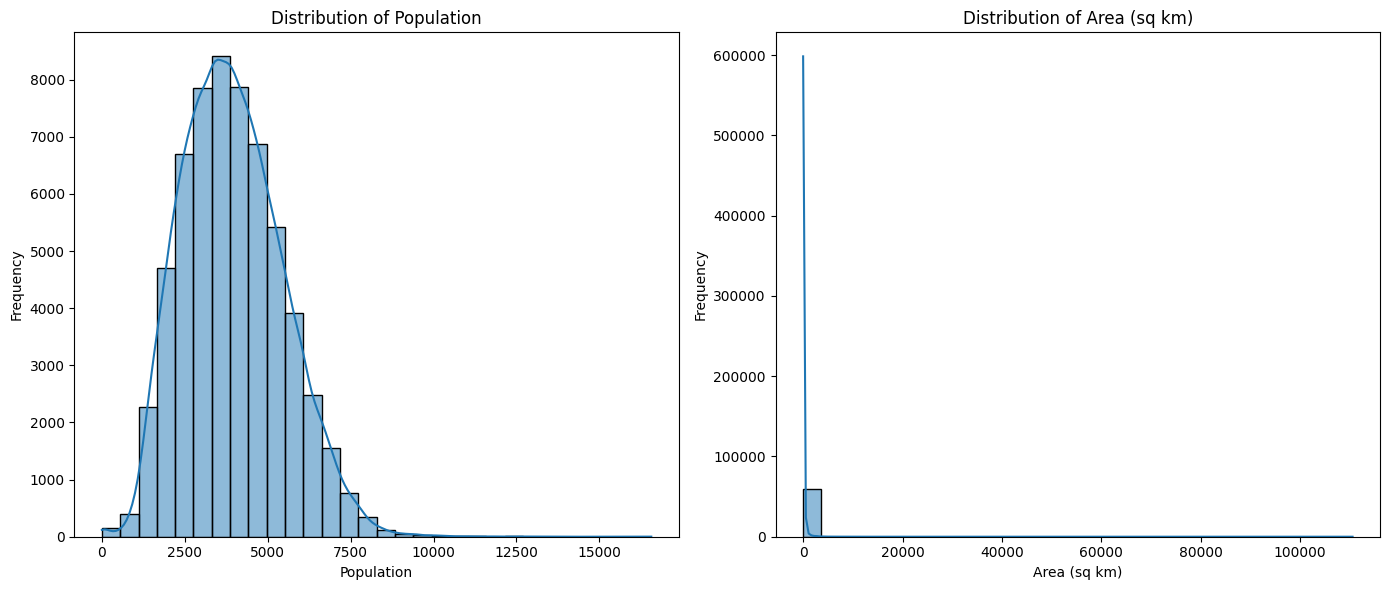

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting environment
plt.figure(figsize=(14, 6))

# Plot Population Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_selected['population'], bins=30, kde=True)
plt.title('Distribution of Population')
plt.xlabel('Population')
plt.ylabel('Frequency')

# Plot Area Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_selected['area_sq_km'], bins=30, kde=True)
plt.title('Distribution of Area (sq km)')
plt.xlabel('Area (sq km)')
plt.ylabel('Frequency')

# Show plots
plt.tight_layout()
plt.show()


In [68]:
df_selected['area_sq_km'].idxmax()

1048

In [85]:
tract_data.iloc[1048]

Unnamed: 0                                                          1048
state_code                                                             2
county_code                                                          290
census_tract_number                                                  2.0
as_of_year                                                          2017
loanN                                                                  7
population                                                          1428
GEOID                                                         2290000200
INTPTLAT                                                       65.992078
INTPTLON                                                     -150.737406
STATEFP                                                                2
COUNTYFP                                                             290
TRACTCE                                                              200
GEOIDFQ                                            

Scraping the following tract, total:  209696


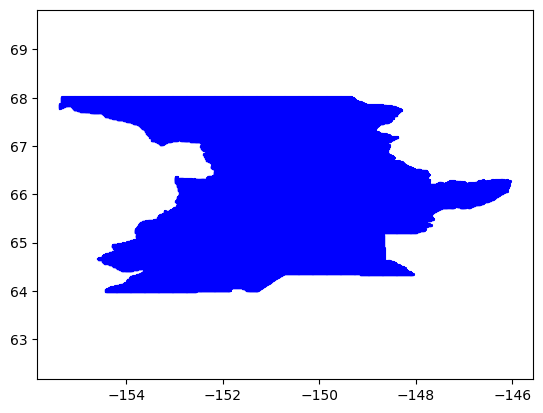

In [73]:
m = main_for_test(tract_data, 1048)
m

### Filtering USA Tracts

In [141]:
def filter_usa_tracts(df):
    min_lat, max_lat = 24.396308, 49.384358
    min_lon, max_lon = -125.0, -66.93457
    # bounding_boxes = [
    #     (24.396308, 49.384358, -125.0, -66.93457),  # Contiguous USA
    #     (51.2097, 71.5388001, -179.148909, -129.9795),  # Alaska
    #     (18.910361, 28.402123, -178.334698, -154.806773)  # Hawaii
    # ]
    # Extract centroid coordinates for filtering
    # df['centroid'] = df['geometry'].centroid
    # df['lat'] = df['centroid'].apply(lambda point: point.y)
    # df['lon'] = df['centroid'].apply(lambda point: point.x)
    # Filter based on bounding box
    df_filtered = df[(df['INTPTLAT'] >= min_lat) & (df['INTPTLAT'] <= max_lat) &
                    (df['INTPTLON'] >= min_lon) & (df['INTPTLON'] <= max_lon)]
    # conditions = [(df['INTPTLAT'] >= min_lat) & (df['INTPTLAT'] <= max_lat) &
    #             (df['INTPTLON'] >= min_lon) & (df['INTPTLON'] <= max_lon)
    #             for (min_lat, max_lat, min_lon, max_lon) in bounding_boxes]

    # # Combine conditions with OR logic
    # combined_condition = conditions[0]
    # for condition in conditions[1:]:
    #     combined_condition |= condition
    
    # df_filtered = df[combined_condition]
    # Drop the temporary columns
    # df_filtered = df_filtered.drop(columns=['centroid', 'lat', 'lon'])
    
    return df_filtered

# Example usage:
tract_data = pd.read_csv('tract_data_final.csv')
tract_data['geometry'] = tract_data['geometry_shape'].apply(wkt.loads)
geo_df = gpd.GeoDataFrame(tract_data, geometry='geometry')

# Calculate areas
geo_df_with_areas = calculate_tract_areas(geo_df)

# Filter to keep only USA tracts
geo_df_usa = filter_usa_tracts(geo_df_with_areas)
geo_df_usa.dropna(inplace=True)

# Select relevant columns for further analysis
df_selected_filtered = geo_df_usa[['state_code', 'county_code', 'GEOID', 'population', 'area_sq_km']]
print(df_selected_filtered)


       state_code  county_code        GEOID  population   area_sq_km
0               1            1   1001020100        1948    11.960556
1               1            1   1001020200        2156     3.965478
2               1            1   1001020300        2968     6.825247
3               1            1   1001020400        4423     7.465518
4               1            1   1001020600        3851    11.312476
...           ...          ...          ...         ...          ...
59157          56           43  56043000200        3256  5861.316852
59158          56           43  56043000301        2578     2.009333
59159          56           43  56043000302        2566    16.910559
59160          56           45  56045951100        3442  6254.878807
59161          56           45  56045951300        3710   109.758976

[58841 rows x 5 columns]


/var/folders/pr/x37_c3g97d7_trhhnhr00k4m0000gn/T/ipykernel_63522/5244100.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df_usa.dropna(inplace=True)


In [143]:
geo_df_usa.to_csv('tract_data_usa.csv')

In [97]:
print(df_selected_filtered['area_sq_km'].max())
df_selected_filtered['area_sq_km'].idxmax()

24660.04442219942


44581

Scraping the following tract, total:  27775


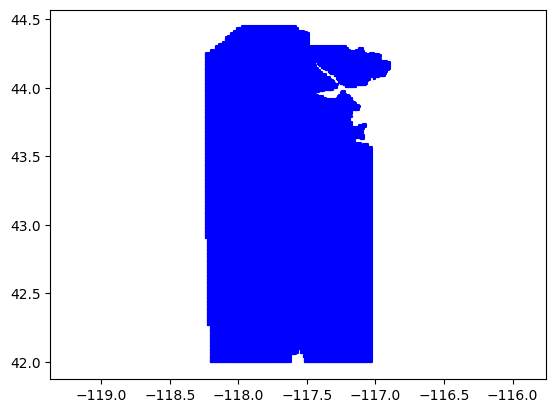

In [82]:
m = main_for_test(tract_data, 44581)
m

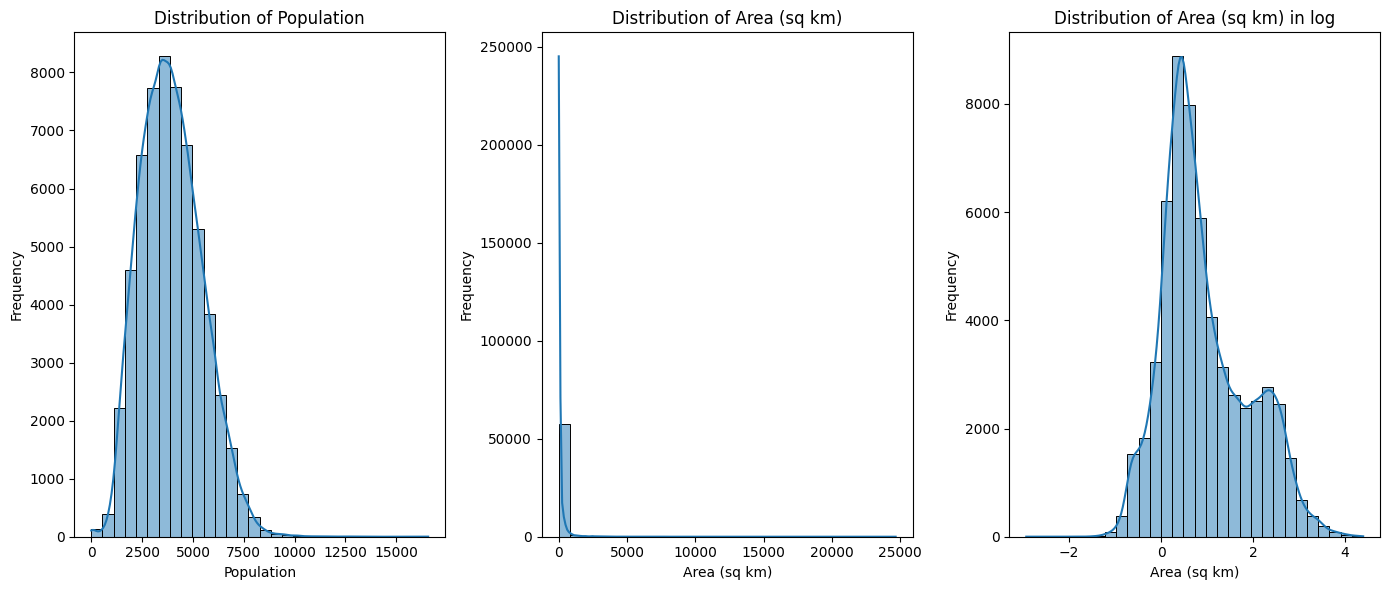

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting environment
plt.figure(figsize=(14, 6))

# Plot Population Distribution
plt.subplot(1, 3, 1)
sns.histplot(df_selected_filtered['population'], bins=30, kde=True)
plt.title('Distribution of Population')
plt.xlabel('Population')
plt.ylabel('Frequency')

# Plot Area Distribution
plt.subplot(1, 3, 2)
sns.histplot(df_selected_filtered['area_sq_km'], bins=30, kde=True)
plt.title('Distribution of Area (sq km)')
plt.xlabel('Area (sq km)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(np.log10(df_selected_filtered['area_sq_km']), bins=30, kde=True)
plt.title('Distribution of Area (sq km) in log')
plt.xlabel('Area (sq km)')
plt.ylabel('Frequency')

# Show plots
plt.tight_layout()
plt.show()


In [112]:
df_above = df_selected_filtered[df_selected_filtered['area_sq_km'] > 100]
df_below = df_selected_filtered[df_selected_filtered['area_sq_km'] < 100]

df_above

,state_code,county_code,GEOID,population,area_sq_km
6,1,1,1001020801,3187,164.034686
7,1,1,1001021000,3286,472.642945
8,1,1,1001021100,3295,598.793642
9,1,3,1003010100,3829,1222.734512
10,1,3,1003010200,2869,269.934221
...,...,...,...,...,...
59152,56,37,56037971000,2118,131.392254
59155,56,37,56037971600,1797,21508.662972
59157,56,43,56043000200,3256,5861.316852
59160,56,45,56045951100,3442,6254.878807


       Area Range  Frequency
0  (-0.001, 20.0]      41191
1   (20.0, 100.0]       7502
2    (100.0, inf]          0


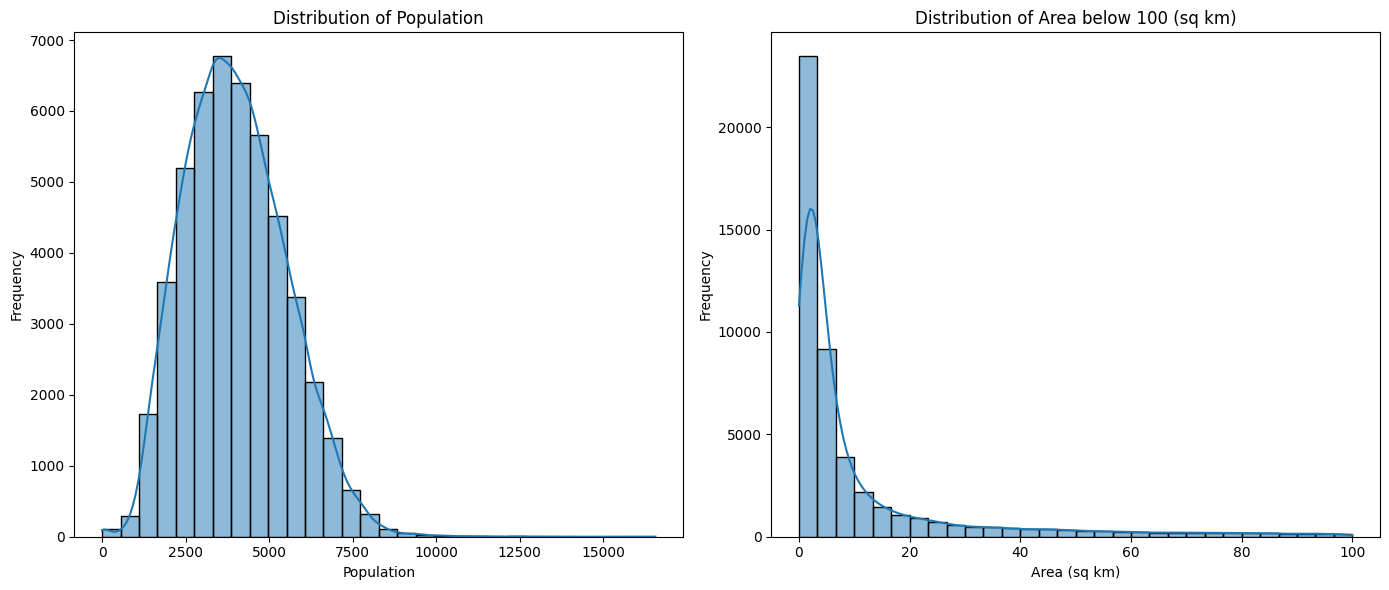

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting environment
plt.figure(figsize=(14, 6))

# Plot Population Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_below['population'], bins=30, kde=True)
plt.title('Distribution of Population')
plt.xlabel('Population')
plt.ylabel('Frequency')

# Plot Area Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_below['area_sq_km'], bins=30, kde=True)
plt.title('Distribution of Area below 100 (sq km)')
plt.xlabel('Area (sq km)')
plt.ylabel('Frequency')

area_freq = df_below['area_sq_km'].value_counts(bins=[0, 20, 100, float('inf')]).reset_index()
area_freq.columns = ['Area Range', 'Frequency']
print(area_freq)
# Show plots
plt.tight_layout()
plt.show()


In [119]:
df_selected_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58841 entries, 0 to 59161
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   state_code   58841 non-null  int64  
 1   county_code  58841 non-null  int64  
 2   GEOID        58841 non-null  int64  
 3   population   58841 non-null  int64  
 4   area_sq_km   58841 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 2.7 MB


        Area Range  Frequency
0   (-0.001, 20.0]      41191
1  (100.0, 1000.0]       9006
2    (20.0, 100.0]       7502
3    (1000.0, inf]       1142


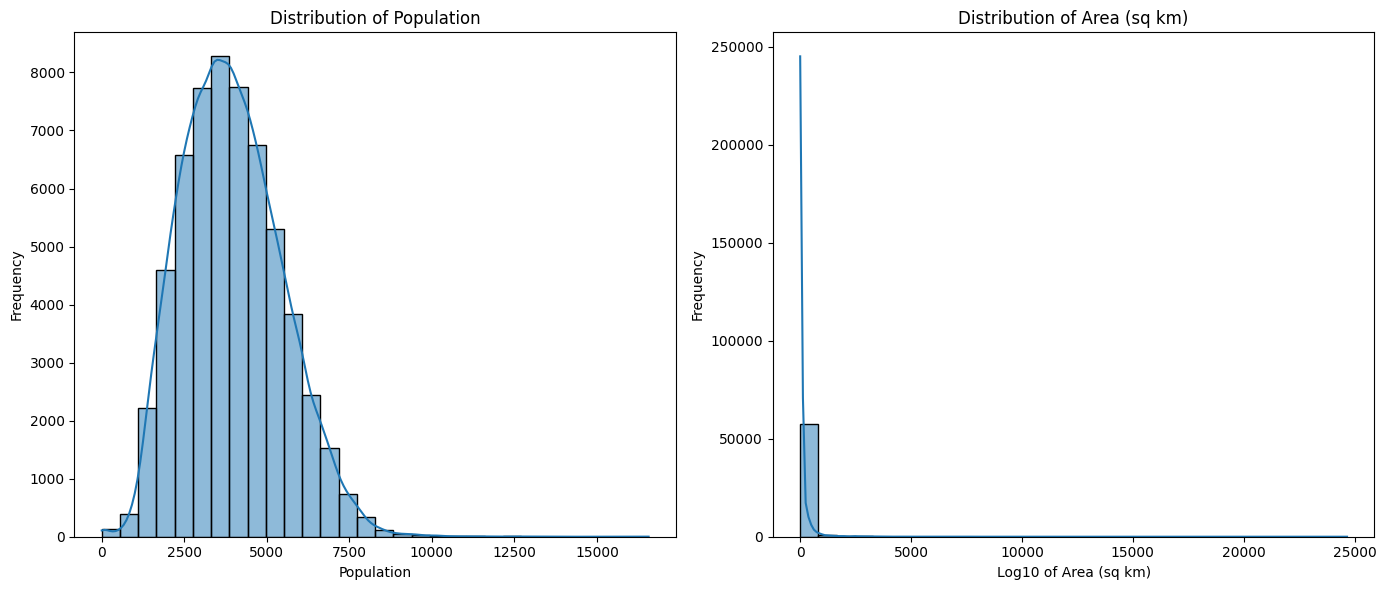

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set up the plotting environment
plt.figure(figsize=(14, 6))

# Plot Population Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_selected_filtered['population'], bins=30, kde=True)
plt.title('Distribution of Population')
plt.xlabel('Population')
plt.ylabel('Frequency')

# Plot Area Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_selected_filtered['area_sq_km'], bins=30, kde=True)
plt.title('Distribution of Area (sq km)')
plt.xlabel('Log10 of Area (sq km)')
plt.ylabel('Frequency')

# Calculate the frequency of area values in different ranges
area_freq = df_selected_filtered['area_sq_km'].value_counts(bins=[0, 20, 100, 1000, float('inf')]).reset_index()
area_freq.columns = ['Area Range', 'Frequency']
print(area_freq)

# Show plots
plt.tight_layout()
plt.show()

In [140]:
tract_data = pd.read_csv('tract_data.csv')
tract_data['geometry_shape'] = tract_data['geometry']
tract_data.to_csv('tract_data_final.csv')

In [142]:
geo_df_usa

,Unnamed: 0.1,Unnamed: 0,state_code,county_code,census_tract_number,as_of_year,loanN,population,GEOID,INTPTLAT,...,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry,geometry_shape,area_sq_m,area_sq_km
0,0,0,1,1,201.00,2017,30,1948,1001020100,32.481973,...,AL,Autauga County,Alabama,CT,9825303,28435,"POLYGON ((3420137.899 4035770.617, 3421094.880...","POLYGON ((-86.510144 32.472434, -86.488262 32....",1.196056e+07,11.960556
1,1,1,1,1,202.00,2017,34,2156,1001020200,32.475758,...,AL,Autauga County,Alabama,CT,3320818,5669,"POLYGON ((3422612.922 4038731.107, 3423764.041...","POLYGON ((-86.478867 32.489342, -86.46731 32.4...",3.965478e+06,3.965478
2,2,2,1,1,203.00,2017,78,2968,1001020300,32.474024,...,AL,Autauga County,Alabama,CT,5349271,9054,"POLYGON ((3423918.248 4037367.173, 3423764.041...","POLYGON ((-86.470868 32.475535, -86.46731 32.4...",6.825247e+06,6.825247
3,3,3,1,1,204.00,2017,100,4423,1001020400,32.471030,...,AL,Autauga County,Alabama,CT,6384282,8408,"POLYGON ((3425014.359 4039822.957, 3425569.659...","POLYGON ((-86.453689 32.491906, -86.44742 32.4...",7.465518e+06,7.465518
4,4,4,1,1,206.00,2017,83,3851,1001020600,32.447340,...,AL,Autauga County,Alabama,CT,8041698,59696,"POLYGON ((3423107.590 4033787.642, 3423272.340...","POLYGON ((-86.488683 32.449727, -86.48188 32.4...",1.131248e+07,11.312476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59157,59157,59157,56,43,2.00,2017,33,3256,56043000200,43.878830,...,WY,Washakie County,Wyoming,CT,5780730054,9728956,"POLYGON ((1175574.022 4925420.592, 1245415.222...","POLYGON ((-108.550562 44.168455, -107.677554 4...",5.861317e+09,5861.316852
59158,59158,59158,56,43,3.01,2017,36,2578,56043000301,44.014369,...,WY,Washakie County,Wyoming,CT,1993200,0,"POLYGON ((1224697.287 4914273.195, 1225526.143...","POLYGON ((-107.958752 44.022466, -107.948426 4...",2.009333e+06,2.009333
59159,59159,59159,56,43,3.02,2017,25,2566,56043000302,44.028771,...,WY,Washakie County,Wyoming,CT,15429216,686934,"POLYGON ((1223213.052 4912957.958, 1224812.550...","POLYGON ((-107.97883 44.012229, -107.95443 44....",1.691056e+07,16.910559
59160,59160,59160,56,45,9511.00,2017,63,3442,56045951100,43.846213,...,WY,Weston County,Wyoming,CT,6100000351,5041727,"POLYGON ((1458586.917 4922207.423, 1453065.526...","POLYGON ((-105.081407 43.826928, -105.079281 4...",6.254879e+09,6254.878807
